In [70]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_csv('./../data/throughput.csv')

In [71]:
values = data['sum_call_count'].values
values = values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 50
X = create_sequences(values_scaled, seq_length)
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X, X)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [84]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super(QuantileLoss, self).__init__()
        self.quantiles = quantiles

    def forward(self, y_true, y_pred):
        losses = []
        for q in self.quantiles:
            errors = y_true - y_pred
            loss = torch.max(q * errors, (q - 1) * errors)
            losses.append(torch.mean(loss))
        return torch.mean(torch.stack(losses))

quantiles = [0.1, 0.5, 0.9]
quantile_loss = QuantileLoss(quantiles)


In [85]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, quantile_loss, hidden_size):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_size, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0),    
            nn.Conv1d(hidden_size, hidden_size//2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0)     
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_size//2, hidden_size//2, 3, padding=1), 
            nn.ReLU(),
            nn.Upsample(scale_factor=2),   
            nn.Conv1d(hidden_size//2, hidden_size, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),   
            nn.Conv1d(hidden_size, len(quantile_loss.quantiles), 3, padding=0),
        )
        self.loss_fn = quantile_loss
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        outputs = self(inputs.permute(0, 2, 1))
        loss = self.loss_fn(outputs, inputs.permute(0, 2, 1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)


In [86]:
model = ConvAutoencoder(quantile_loss, hidden_size=32)
trainer = pl.Trainer(max_epochs=50, logger=True, log_every_n_steps=1)
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type         | Params
-----------------------------------------
0 | encoder | Sequential   | 1.6 K 
1 | decoder | Sequential   | 2.6 K 
2 | loss_fn | QuantileLoss | 0     
-----------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)
d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1:  42%|████▏     | 565/1351 [00:09<00:13, 58.01it/s, v_num=3, train_loss_step=0.00265, train_loss_epoch=0.00585]

d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [165]:
import matplotlib.pyplot as plt
import numpy as np

def plot_time_series_with_quantiles(time_series, quantiles, seq_length, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    
    # Plot the quantiles
    for index in range(0,len(quantile_predictions)//2):
        print()
        plt.fill_between(np.arange(seq_length, len(time_series) + 1), 
                         quantiles[index], quantiles[len(quantile_predictions)-index-1], label=f'Quantile {index+1}',)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Example usage
# Assuming `actual_values` is a numpy array of the actual time series values
# and `predicted_quantiles` is a numpy array of shape (n_samples, n_quantiles, seq_length)

# actual_values = np.array(...)  # Your actual time series values
# predicted_quantiles = np.array(...)  # The predicted quantiles from the model

# plot_time_series_with_quantiles(actual_values, predicted_quantiles, seq_length=56)


In [166]:
inputs = dataset[0][0].permute(1, 0)
model.eval()
with torch.no_grad():
    quantile_predictions = model(inputs.unsqueeze(0))  # Shape: (1, n_quantiles, seq_length)


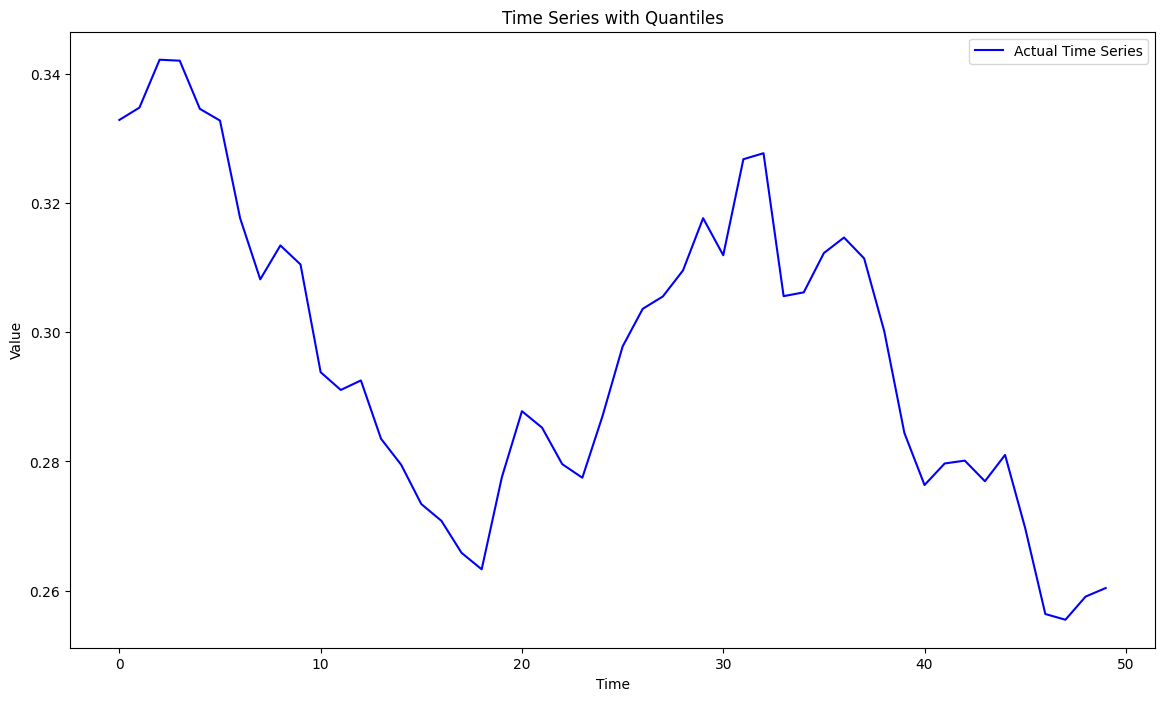

In [167]:
plot_time_series_with_quantiles(inputs.squeeze(0).numpy(), quantile_predictions.squeeze(0), 50)

In [168]:
quantile_predictions.squeeze(0)

tensor([[0.3377, 0.3389, 0.3377, 0.3366, 0.3341, 0.3312, 0.3184, 0.3127, 0.3065,
         0.3038, 0.2994, 0.2947, 0.2868, 0.2823, 0.2762, 0.2721, 0.2704, 0.2704,
         0.2710, 0.2723, 0.2763, 0.2787, 0.2812, 0.2841, 0.2894, 0.2932, 0.2997,
         0.3041, 0.3127, 0.3156, 0.3207, 0.3217, 0.3175, 0.3144, 0.3104, 0.3087,
         0.3061, 0.3040, 0.2951, 0.2905, 0.2834, 0.2803, 0.2762, 0.2764, 0.2716,
         0.2690, 0.2630, 0.2609, 0.2558, 0.2553],
        [0.3384, 0.3397, 0.3385, 0.3378, 0.3346, 0.3313, 0.3189, 0.3142, 0.3073,
         0.3031, 0.2985, 0.2949, 0.2868, 0.2827, 0.2758, 0.2729, 0.2705, 0.2699,
         0.2704, 0.2723, 0.2761, 0.2782, 0.2811, 0.2837, 0.2890, 0.2931, 0.3001,
         0.3044, 0.3130, 0.3159, 0.3215, 0.3217, 0.3181, 0.3149, 0.3102, 0.3086,
         0.3062, 0.3035, 0.2939, 0.2893, 0.2817, 0.2812, 0.2752, 0.2738, 0.2703,
         0.2683, 0.2622, 0.2596, 0.2545, 0.2555],
        [0.3382, 0.3386, 0.3388, 0.3382, 0.3347, 0.3293, 0.3224, 0.3139, 0.3067,
         

In [169]:
plt.fill_between?

Signature:
plt.fill_between(
    x: 'ArrayLike',
    y1: 'ArrayLike | float',
    y2: 'ArrayLike | float' = 0,
    where: 'Sequence[bool] | None' = None,
    interpolate: 'bool' = False,
    step: "Literal['pre', 'post', 'mid'] | None" = None,
    *,
    data=None,
    **kwargs,
) -> 'PolyCollection'
Docstring:
Fill the area between two horizontal curves.

The curves are defined by the points (*x*, *y1*) and (*x*,
*y2*).  This creates one or multiple polygons describing the filled
area.

You may exclude some horizontal sections from filling using *where*.

By default, the edges connect the given points directly.  Use *step*
if the filling should be a step function, i.e. constant in between
*x*.

Parameters
----------
x : array (length N)
    The x coordinates of the nodes defining the curves.

y1 : array (length N) or scalar
    The y coordinates of the nodes defining the first curve.

y2 : array (length N) or scalar, default: 0
    The y coordinates of the nodes defining the second cu